In [167]:
import h5py
import glob
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy.signal import butter
from scipy.optimize import curve_fit
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ExponentialModel

In [168]:
# reading h5 file
f = h5py.File("20190518_173944_projection-Copy1.h5")
list(f.keys())
shots = f.get("n-shots")
photE = f.get("x-axis")
intense = f.get("y-axis")
spectrum = range(0,len(intense[:,1]-1))

Filter thresholds & other function inputs

In [169]:
# Low pass filter:
lpcutoff = 0.005
lowpassdata = intense[0,:]
heightcut = 5
dx = 0.1
sidecut = 5

### Defining functions

Low-pass filter

In [170]:
def lowpass(lowpassdata, lpcutoff):
    b, a = signal.butter(5, lpcutoff, 'low')
    spec = signal.filtfilt(b, a, lowpassdata)
    return spec

In [171]:
spec = lowpass(lowpassdata,lpcutoff)
def shift(lowpassdata, lpcutoff):
    return min(spec)
def MaxPeak(lowpassdata, lpcutoff):
    return max(spec)
def dataRawS(lowpassdata, lpcutoff):
    drs = np.array([photE,lowpassdata-shift(lowpassdata,lpcutoff)]).T
    return drs
def Noise(lowpassdata, lpcutoff):
        noise = np.array([photE,lowpassdata-spec]).T
        return noise
def IIData(lowpassdata, lpcutoff):
    return sum(spec-shift(lowpassdata,lpcutoff))
def IINoise(lowpassdata, lpcutoff):
    return sum(lowpassdata-spec)
def IIDataRaw(lowpassdata, lpcutoff):
    return sum(lowpassdata)
def data(lowpassdata,lpcutoff):
    return np.array([photE,spec-shift(lowpassdata,lpcutoff)]).T
    

In [172]:
def plotlowpass(lowpassdata,lpcutoff):
    plt.plot(photE, lowpassdata, label='Raw data')
    plt.plot(photE, lowpass(lowpassdata,lpcutoff), label='filtered')
    plt.plot(photE,data(lowpassdata,lpcutoff)[:,1],label = 'shift adjusted')
    plt.plot(photE,Noise(lowpassdata,lpcutoff)[:,1],label = 'noise')

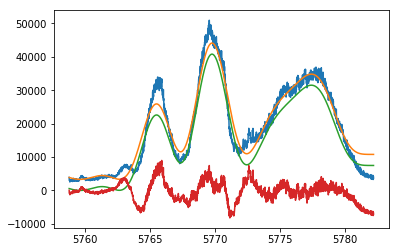

In [173]:
# TEST
plotlowpass(lowpassdata,lpcutoff)

Finding peaks

In [174]:
SD = np.std(lowpassdata-spec)
h = (max(Data[:,1]/(100*heightcut)))
Data = data(lowpassdata, lpcutoff)
peaks = sp.signal.find_peaks(Data[:,1],
                             height=h,
                             distance = SD/10)
pospeaks = np.asarray(np.asarray(peaks)[0])
xpeaks = Data[pospeaks,0]
ypeaks = np.asarray(((str(np.asarray(peaks)[1])).split("array(")[1]).split(")")[0])
Peaks = np.array([xpeaks,ypeaks]).T

In [184]:
n = len(Peaks)
if n > 1:
    # checking for close peaks
    while j <= n:
        if np.sort(abs(xpeaks-xpeaks[j]))[1]<dx:
            peaks = remove(peaks[j])
            pospeaks = peaks[:,0]
            xpeaks = Data[pospeaks,0]
            ypeaks = peaks[:,1]
        j = j+1
    Peaks = np.array([xpeaks,ypeaks]).T
    # eliminating peaks close to edge
    while j <= n:
        if abs(xpeaks[j] - max(photE) < ((max[photE] - min[photE])*sidecut/100)) or (abs[xpeaks[[j]] - min[photE]] < ((max[photE] - min[photE])*sidecut/100)):
            peaks = remove(peaks[j])
            pospeaks = peaks[:,0]
            xpeaks = Data[pospeaks,0]
            ypeaks = peaks[:,1]
        j = j + 1
    Peaks = np.array([xpeaks,ypeaks]).T
    n = len(Peaks)

Simple model fit, no conditions

In [185]:
def peakfunc(A, mu, sigma, x):
    return A**2 * np.exp(-((x-mu)**2/(2*sigma**2)))
def peakfuncB(A, mu, sigma, x):
    return A * np.exp(-((x-mu)**2/(2*sigma**2)))

In [186]:
# need to feed a, mu, sigma to function. Maybe integrate with peakfunc
def modelFM(data, n, g):
    dataconfig = A, mu, sigma # would create map, but n = 1 as defined later
    def Guess(muG):
        g = muG
    dataconfigG =
    modelfunc = peakfunc(data)
    objfunc = sum(Data[:,1]-modelfunc)
    bbM = 

SyntaxError: invalid syntax (<ipython-input-186-0f6f468d6514>, line 2)

In [ ]:
def FitFunction(FileName,i,dx,wLPF,sidecut,heightcut):
    MinPeaksPos = np.array([0,n+1])
    MinPeaks = np.array([0,n+1])
    MinPeaksPos[0] = 1
    MinPeaksPos[-1] = -1
    while j <= n-1:
        index1 = pospeaks[j]
        index2 = pospeaks[j+1]
        a = (Data[:,1])[index1:index2]
        MinPeaksPos[j+1] = np.where(a = min(a)[0,0]+pospeaks[j])
        j = j + 1
    MinPeaks = Data[MinPeaksPos]
    sigxAll = np.array([0,n])
    I0All = np.array([0,n])
    xiAll = np.array([0,n])
    resfunc = np.array([0,n])
    while j <= n:
        index1 = MinPeaksPos[j]
        index2 = MinPeaksPos[j+1]
        datapiece = Data[index1:index2]
        modelFM(datapiece,1,Peaks[j,1])
        
        sigxAll[j] = abs(sigma)
    plt.plot()

In [50]:
"""def lowpass(lowpassdata, lpcutoff):
    # Butterworth low pass filter
    plt.plot(photE, lowpassdata, label='Raw data')
    b, a = signal.butter(5, lpcutoff, 'low')
    spec = signal.filtfilt(b, a, lowpassdata)
    plt.plot(photE, spec, label='filtered')
    
    # Other definitions probably useful within function
    shift = min(spec)
    MaxPeak = max(spec)
    dataRawS = np.array([photE,lowpassdata-shift]).T
    Noise = np.array([photE,lowpassdata-spec]).T
    IIData = sum(spec-shift)
    IINoise = sum(lowpassdata-spec)
    IIDataRaw = sum(lowpassdata)
    
    # Collected data set, shift adjusted
    data = np.array([photE,spec-shift]).T
    
    plt.plot(photE,data[:,1],label = 'shift adjusted')
    plt.plot(photE,Noise[:,1],label = 'noise')
    
    plt.legend()
    plt.show()    
    print("With frequency cut-off: ",lpcutoff)
    return spec, photE"""

In [34]:
"""class mod1:
    def __init__(self, lowpassdata,lpcutoff):
        self.lowpassdata = lowpassdata
        self.lpcutoff = lpcutoff
    
    def lowpass(self):
        b, a = signal.butter(5, self.lpcutoff, 'low')
        spec = signal.filtfilt(b, a, self.lowpassdata)
        return spec
    
    def getshift(lowpass):
        shift = min(lowpass(self))
    
    def get"""